# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 


# Start

In [114]:
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:ScottPlot"

using System;
using System.Reflection;

using Microsoft.DotNet.Interactive.Formatting;

using Microsoft.Data.Analysis;

using Newtonsoft.Json;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

In [207]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);

class PlotBuilder {
    ScottPlot.Plot plot = new ();
    public PlotBuilder Add<T1, T2> (List<T1> x, List<T2> y, string legend = default) {
        plot.Add.Scatter(x, y).LegendText = legend ?? "";
        return this;
    }
    public PlotBuilder Add<T> (List<T> y, string legend = default) => Add(Enumerable.Range(0, y.Count).ToList(), y, legend);
    public PlotBuilder Add<T> (List<(T,T)> y, (string, string) legend = default) =>
        Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2);
    public PlotBuilder Add<T> (List<(T,T,T)> y, (string, string, string) legend = default) => 
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2)
        .Add(y.Select(y => y.Item3).ToList(), legend.Item3);


    public ScottPlot.Plot Build () => plot;
}


In [200]:
static DataFrame CreateDataFrame<T> (List<T> objects) {
    Type type = typeof(T);
    FieldInfo[] fields = type.GetFields(BindingFlags.Public | BindingFlags.Instance);
    List<(string, Type)> names = fields.Select(f => (f.Name, f.FieldType)).ToList();
    var boxed = objects.Select(item => fields.Select(f => f.GetValue(item)).ToList());

    return DataFrame.LoadFrom(boxed, names);
}

/*
static DataFrame GetDataFrame<T> (List<T> objects, string prefix = "") {
    Type type = typeof(T);
    if (type == typeof(int) || type == typeof(float) || type == typeof(string)) {
        var boxed = objects.Select(item => new List<object> { item });
        var names = new [] { (prefix, type) };
        return DataFrame.LoadFrom(boxed, names);
    }

    FieldInfo[] fields = type.GetFields(BindingFlags.Public | BindingFlags.Instance);
    List<DataFrame> dataFrames = fields.Select(field => {
        var values = objects.Select(item => field.GetValue(item)).ToList();
        Console.WriteLine(field.ToString());
        Console.WriteLine(field.GetValue(objects[0]));
        return GetDataFrame(values, $"{prefix}.{field.Name}");
    }).ToList();
    dataFrames.ForEach(item => Console.WriteLine(item));
    List<DataFrameColumn> columns = dataFrames.SelectMany(d => d.Columns).ToList();
    return new DataFrame(columns);
}*/


static DataFrame CreateDataFrame<T> (params T[] objects) => CreateDataFrame(objects.ToList());
static DataFrame ToDataFrame<T>(this List<T> objects) => CreateDataFrame(objects); 
static DataFrame ToDataFrame<T>(this T item) => CreateDataFrame(item); 
static void Log(this object item) => Console.WriteLine(item);


In [201]:
static string DumpS(this object value)
{
    return JsonConvert.SerializeObject(value, Formatting.None);
}

static T[] DumpMulti<T> (this T[] values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static IEnumerable<T> DumpMulti<T> (this IEnumerable<T> values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static T Dump<T>(this T value) => DumpOneLine(value);

static T DumpOneLine<T> (this T value) {
    Console.WriteLine(value.DumpS());
    return value;
}

# Simulation

In [223]:
public partial struct Market
{
    public uint Food, Oxygen, Minerals, Water;
}

public struct Population
{
    public uint Farmers, Laborers, Engineers;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}

public struct Points 
{
    public int Value;
}

In [224]:
static Market sub(Market a, Market b)
{
    return new Market
    {
        Food = a.Food - b.Food,
        Oxygen = a.Oxygen - b.Oxygen,
        Minerals = a.Minerals - b.Minerals,
        Water = a.Water - b.Water
    };
}
static uint sum (this Population a) => a.Farmers + a.Laborers + a.Engineers; 

In [225]:
void Build(in Population population, ref Market market)
{
    market.Food = population.Farmers* 5;
    market.Minerals = population.Laborers;
    market.Oxygen = population.Engineers * 100;
    market.Water = population.Engineers * 20;
}

In [226]:
void Consume(Market market, ref Population population, out Market leftovers)
{

    uint populationSum = population.sum();
    uint oxygenNeed = populationSum;
    uint foodNeed = populationSum;
    uint waterNeed = populationSum;

    Market bought = new();

    bought.Oxygen = Math.Min(market.Oxygen, oxygenNeed);
    bought.Food = Math.Min(market.Food, foodNeed);
    bought.Water = Math.Min(market.Water, waterNeed);

    market = sub(market, bought);

    float oxygenRatio = (float)bought.Oxygen / oxygenNeed;
    float foodRatio = (float)bought.Food / foodNeed;
    float waterRatio = (float) bought.Water / waterNeed;

    leftovers = market;

    // pops
    float decrease = Math.Clamp(oxygenRatio, 0.8f, 1);
    float increase = 0.02f;

    uint children = (uint) (populationSum * increase);
    checked {

    population.Farmers   = (uint)(population.Farmers   * decrease);
    population.Laborers  = (uint)(population.Laborers  * decrease);
    population.Engineers = (uint)(population.Engineers * decrease);


    // education, so chicldren from engineers start educated and cna become engineers, rest cant. So only promotions.
    if (oxygenRatio < 1 || waterRatio < 1)
    {
        population.Engineers += children;
    }
    else if (foodRatio < 1)
    {                           
        population.Farmers += children;
    }
    else
    {
        population.Laborers += children;
    }
    }
    // Log Death
    
    if (population.sum() < populationSum)
        new object[] { $"Sim Stats, pop {populationSum}, +{increase:0.00}, children {children}, -{1-decrease:0.00}, O2 {oxygenRatio}" }.DumpOneLine();

//        new object[] { $"Stats for simulation, population {populationSum}, increase {increase}, children {children}, decrease {decrease}" }.DumpOneLine();
}


{"Farmers":10,"Laborers":1000,"Engineers":10}
{"Food":0,"Oxygen":0,"Minerals":0,"Water":0}
["Sim Stats, pop 1020, +0.02, children 20, -0.02, O2 0.98039216"]
["Sim Stats, pop 700618049, +0.02, children 14012361, -0.20, O2 0.729533"]
["Sim Stats, pop 1470756480, +0.02, children 29415128, -0.04, O2 0.9565612"]
["Sim Stats, pop 2601629136, +0.02, children 52032584, -0.20, O2 0.16352507"]
["Sim Stats, pop 2150297500, +0.02, children 43005952, -0.14, O2 0.85892105"]
["Sim Stats, pop 1966295452, +0.02, children 39325908, -0.03, O2 0.96768355"]
["Sim Stats, pop 1942077748, +0.02, children 38841552, -0.20, O2 0.2612153"]
["Sim Stats, pop 1747490104, +0.02, children 34949800, -0.20, O2 0.3818002"]
["Sim Stats, pop 2630000440, +0.02, children 52600008, -0.20, O2 0.27739522"]
["Sim Stats, pop 2759181404, +0.02, children 55183624, -0.20, O2 0.14092009"]
["Sim Stats, pop 2307779312, +0.02, children 46155584, -0.20, O2 0.020174047"]
["Sim Stats, pop 2030259004, +0.02, children 40605176, -0.20, O2 0.6


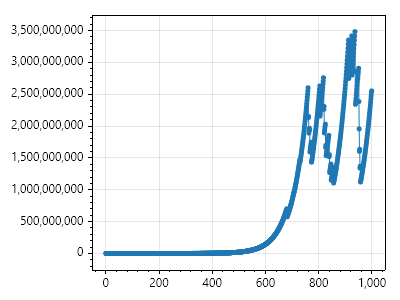

In [228]:
Market market;
Population population = new Population { Engineers = 10, Farmers = 10, Laborers = 1000 };
Points points;


void SimulateStep () {
    market = default(Market);
    Build(in population, ref market);
    Consume(market, ref population, out Market leftovers);
}


List<Population> populations = new ();
List<Market> markets = new ();
new object[] {population, market}.Dump();
for (int i = 0; i < 1000; i++) {
    SimulateStep();
    markets.Add(market);
    populations.Add(population);
}
new object[] {"After Simulation", population, market}.DumpOneLine();


new PlotBuilder().Add(populations.Select(pop => pop.sum()).ToList()).Build()



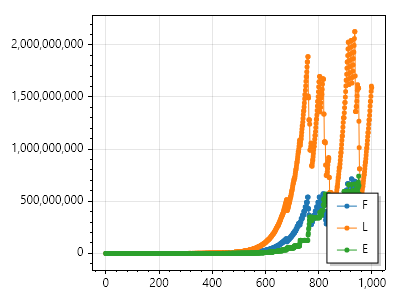

In [227]:
new PlotBuilder().Add(populations.Select(pop => (pop.Farmers, pop.Laborers, pop.Engineers)).ToList(), ("F", "L", "E")).Build()


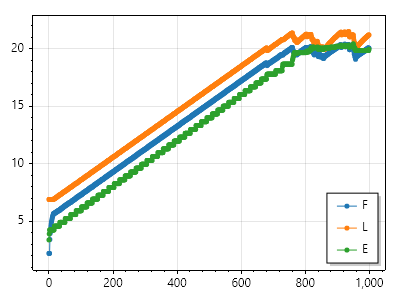

In [229]:
new PlotBuilder().Add(populations.Select(pop => (Math.Log(pop.Farmers), Math.Log(pop.Laborers), Math.Log(pop.Engineers))).ToList(), ("F", "L", "E")).Build()


In [230]:
market.ToDataFrame()

index,Food,Oxygen,Minerals,Water
0,2554986880,2501857536,1603906488,3936345344


In [231]:
var pop = populations.ToDataFrame();
var mrk = markets.ToDataFrame();

In [232]:
new DataFrame(pop.Columns.Concat(mrk.Columns))


index,Farmers,Laborers,Engineers,Food,Oxygen,Minerals,Water
0,9,980,29,50,1000,1000,200
1,9,980,49,45,2900,980,580
2,9,980,69,45,4900,980,980
3,30,980,69,45,6900,980,1380
4,51,980,69,150,6900,980,1380
5,73,980,69,255,6900,980,1380
6,95,980,69,365,6900,980,1380
7,117,980,69,475,6900,980,1380
8,140,980,69,585,6900,980,1380
9,163,980,69,700,6900,980,1380
